In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.2.1+cu121
GPU 사용 가능 여부: True


In [37]:
torch.manual_seed(777)
if device=='cuda':
  torch.cuda.manual_seed_all(777)

In [38]:
data_dir='./content/drive/MyDrive/코딩공부/Pytorch_naver_ai/chair_discrimation/archive (1)'

In [39]:
batch_size=100
num_epochs=10
learning_rate=0.00001

In [40]:
class ChairDataset(Dataset):
  def __init__(self,data_dir,mode,transform=None):
    self.all_data=sorted(glob.glob(os.path.join(data_dir,mode,'*','*')))
    self.transform=transform

  def __getitem__(self,index):
    data_path=self.all_data[index]
    img=Image.open(data_path)
    if self.transform:
      img=self.transform(img)

    if(os.path.basename(data_path).startswith("bike")):
      label=1
    if os.path.basename(data_path)[0].isdigit() or os.path.basename(data_path).startswith("img"):
      label=0
    return img,label

  def __len__(self):
    length=len(self.all_data)
    return length


In [61]:
data_transforms = { #데이터의 증식 방법 선언
    'train': transforms.Compose([ #여러개 선언할 때 사용
        transforms.RandomRotation(5), #무작위 회전
        transforms.RandomHorizontalFlip(),#수직 회전
        transforms.RandomResizedCrop(120, scale=(0.96, 1.0), ratio=(0.95, 1.05)),# 120*120으로 만들어 상하좌우 크기 변경
        transforms.ToTensor(),#텐서로 변경
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #정규화
    ]),
    'val': transforms.Compose([# 위와 똑같이 변형
        transforms.Resize([120, 120]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data=ChairDataset(data_dir='/content/drive/MyDrive/코딩공부/Pytorch_naver_ai/chair_discrimation/archive (1)',mode='train',transform=data_transforms['train'])
val_data=ChairDataset(data_dir='/content/drive/MyDrive/코딩공부/Pytorch_naver_ai/chair_discrimation/archive (1)',mode='val',transform=data_transforms['val'])
test_data=ChairDataset(data_dir='/content/drive/MyDrive/코딩공부/Pytorch_naver_ai/chair_discrimation/archive (1)',mode='test',transform=data_transforms['val'])

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
val_loader=DataLoader(val_data,batch_size=batch_size,shuffle=False,drop_last=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False,drop_last=True)

In [42]:
print(train_data)

In [43]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(3,32,kernel_size=(3,3)),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(32,64,kernel_size=(3,3)),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(64,128,kernel_size=(3,3)),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(128,128,kernel_size=(3,3)),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )

    self.fc1=nn.Linear(128*5*5,512)
    self.fc2=nn.Linear(512,2)

  def forward(self,x):
    x=self.conv(x)
    x=x.view(x.shape[0],-1)
    x=F.relu(self.fc1(x))
    x=self.fc2(x)
    return x

In [54]:
def train(num_epochs,model,data_loader,criterion,optimizer,saved_dir,val_every,device):
  print('Start training..')
  best_loss = 9999999
  for epoch in range(num_epochs):
    for i,(imgs,labels) in enumerate(data_loader):
      imgs,labels=imgs.to(device), labels.to(device)
      outputs=model(imgs)
      loss=criterion(outputs,labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, argmax = torch.max(outputs, 1)
      accuracy = (labels == argmax).float().mean()
      if (i+1) % 3 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch+1, num_epochs, i+1, len(data_loader), loss.item(), accuracy.item() * 100))
    if (epoch + 1) % val_every == 0:
      avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
      if avrg_loss < best_loss:
        print('Best performance at epoch: {}'.format(epoch + 1))
        print('Save model in', saved_dir)
        best_loss = avrg_loss
        save_model(model, saved_dir)

In [70]:
def validation(epoch,model,data_loader,criterion,device):
  print('Start validation #{}'.format(epoch) )
  model.eval()
  with torch.no_grad():
    total=0
    correct=0
    total_loss=0
    cnt=0
    for i,(imgs,labels) in enumerate(data_loader):
      imgs,labels=imgs.to(device),labels.to(device)
      outputs=model(imgs)
      loss=criterion(outputs,labels)
      total+=imgs.size(0)
      _, argmax = torch.max(outputs, 1)
      accuracy = (labels == argmax).float().mean()
      total_loss+=loss
      cnt+=1
    avrg_loss=total_loss/cnt
    print('Validation #{}  Accuracy: {:.2f}%  Average Loss: {:.4f}'.format(epoch, correct / total * 100, avrg_loss))
  model.train()
  return avrg_loss

In [46]:
def test(model,data_loader,device):
  print("start test")
  model.eval()
  with torch.no_grad():
    correct=0
    total=0
    for i,(imgs,labels) in enumerate(data_loader):
      imgs,labels=imgs.to(device),labels.to(device)
      outputs=model(data_loader)
      _,argmax=torch.max(outputs,1)
      total+=imgs.size(0)
      correct+=(labels==argmax).sum().item()
    print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
  model.train()

In [47]:
def save_model(model,saved_dir,file_name='best_model.pt'):
  os.makedirs(saved_dir,exist_ok=True)
  check_point={
      'net':model.state_dict()
  }
  output_path=os.path.join(saved_dir,file_name)
  torch.save(check_point,output_path)

In [59]:
model=SimpleCNN()
model=model.to(device)

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=learning_rate)

model=model.to(device)
val_every=1
saved_dir='./saved/SimpleCNN'

In [62]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

1107
107
52


In [71]:
train(num_epochs, model, train_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/10], Step [3/11], Loss: 0.5463, Accuracy: 76.00%
Epoch [1/10], Step [6/11], Loss: 0.6023, Accuracy: 67.00%
Epoch [1/10], Step [9/11], Loss: 0.5847, Accuracy: 70.00%
Start validation #1
Validation #1  Accuracy: 0.00%  Average Loss: 0.6159
Best performance at epoch: 1
Save model in ./saved/SimpleCNN
Epoch [2/10], Step [3/11], Loss: 0.5588, Accuracy: 69.00%
Epoch [2/10], Step [6/11], Loss: 0.4526, Accuracy: 82.00%
Epoch [2/10], Step [9/11], Loss: 0.5387, Accuracy: 74.00%
Start validation #2
Validation #2  Accuracy: 0.00%  Average Loss: 0.5773
Best performance at epoch: 2
Save model in ./saved/SimpleCNN
Epoch [3/10], Step [3/11], Loss: 0.4524, Accuracy: 83.00%
Epoch [3/10], Step [6/11], Loss: 0.4902, Accuracy: 78.00%
Epoch [3/10], Step [9/11], Loss: 0.4370, Accuracy: 84.00%
Start validation #3
Validation #3  Accuracy: 0.00%  Average Loss: 0.5388
Best performance at epoch: 3
Save model in ./saved/SimpleCNN
Epoch [4/10], Step [3/11], Loss: 0.4669, Accuracy: 79.00%
E

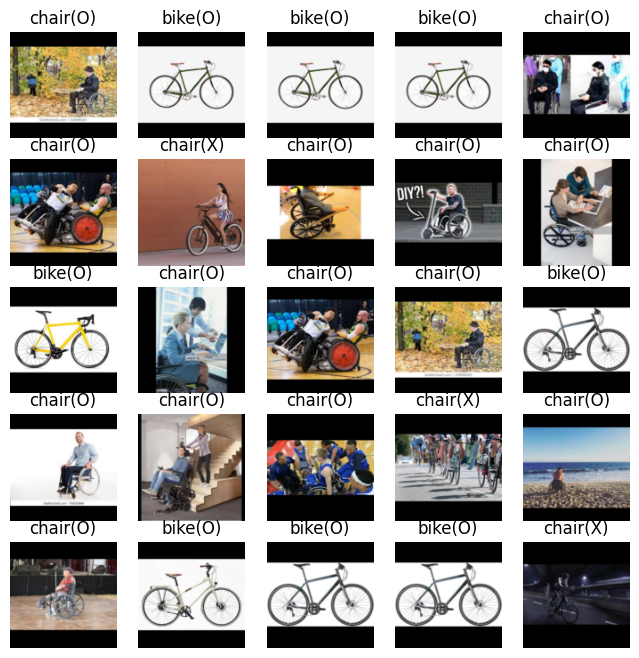

In [72]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device)
    '''
    unsqueeze()를 통해 입력 이미지의 shape을 (1, 28, 28)에서 (1, 1, 28, 28)로 변환.
    모델에 들어가는 입력 이미지의 shape은 (batch_size, channel, width, height) 되어야 함에 주의하세요!
    '''
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = argmax.item()
    label = test_data[data_idx][1]

    fig.add_subplot(rows, columns, i)
    pred_title = 'chair' if pred == 0 else 'bike'
    if pred == label:
        plt.title(pred_title + '(O)')
    else:
        plt.title(pred_title + '(X)')
    plot_img = test_data[data_idx][0]
    # 이미지를 normalization 이전 상태로 되돌리는 작업
    plot_img[0, :, :] = plot_img[0, :, :] * std[0] + mean[0]
    plot_img[1, :, :] = plot_img[1, :, :] * std[1] + mean[1]
    plot_img[2, :, :] = plot_img[2, :, :] * std[2] + mean[2]
    plot_img = transforms.functional.to_pil_image(plot_img)
    plt.imshow(plot_img)
    plt.axis('off')
plt.show()